### The Road Ahead

We break the notebook into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [43]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("to\dog-project\lfw\*\*"))
dog_files = np.array(glob("to\dog-project\dogImages\*\*\*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). In the next code cell, we use this detector to find human faces in a sample image.

Number of faces detected: 1


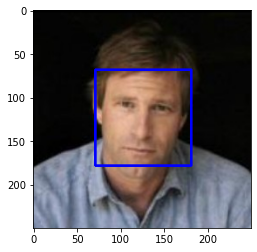

In [44]:
import cv2                
import matplotlib.pyplot as plt
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [45]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Let us test the performance of the `face_detector` 
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. We can see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [46]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm
## on the images in human_files_short and dog_files_short.
human_score = 0
dog_score = 0
for i in tqdm(range(len(human_files_short))):
    if face_detector(human_files_short[i]):
        human_score += 1
    if face_detector(dog_files_short[i]):
        dog_score += 1
print(human_score/len(human_files_short)*100,"% of human face detected in human images")
print(dog_score/len(dog_files_short)*100,"% of human face detected in dog images")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]

96.0 % of human face detected in human images
18.0 % of human face detected in dog images


Let us try another face detector using `mtcnn` and report performance on `human_files_short` and `dog_files_short`.

In [51]:
import warnings
warnings.filterwarnings("ignore")

import mtcnn
from mtcnn.mtcnn import MTCNN

In [49]:
def face_detector_2(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = MTCNN().detect_faces(cv_rgb)
    return len(faces) > 0

In [52]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm
## on the images in human_files_short and dog_files_short.
human_score = 0
dog_score = 0
for i in tqdm(range(len(human_files_short))):
    if face_detector_2(human_files_short[i]):
        human_score += 1
    if face_detector_2(dog_files_short[i]):
        dog_score += 1
print(human_score/len(human_files_short)*100,"% of human face detected in human images")
print(dog_score/len(dog_files_short)*100,"% of human face detected in dog images")

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:25:27<00:00, 51.27s/it]

100.0 % of human face detected in human images
18.0 % of human face detected in dog images


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [53]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

Function below accepts path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. The output is an integer between 0 and 999, inclusive.

Model architectures of various pre-trained models for image classification can be found [here](http://pytorch.org/docs/stable/torchvision/models.html).

In [54]:
import torchvision.transforms as transforms

from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''   
    Args:
        img_path: path to an image 
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    # VGG-16 Takes 224x224 images as input, so we resize all of them
    img = Image.open(img_path).convert('RGB')
    data_transform = transforms.Compose([transforms.Resize(255),
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])
    
    image = data_transform(img).reshape(1,3,224,224)                   #data_transform(img)[:3,:,:].unsqueeze(0)
    image = image.cuda()
    
    # Set model for evaluation
    VGG16.train(False)
    VGG16.eval()
    
    outputs = VGG16(image)
    _, preds = torch.max(outputs.data, 1)
    preds = preds.cpu().detach().numpy()[0]
    
    return preds # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we can notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need to only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

`dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [55]:
def dog_detector(img_path):
    preds = VGG16_predict(img_path)
    return preds in range(151,269)         #returns True if preds in range(151,269) else False

### Assess the Dog Detector

Let us test the performance of your `dog_detector`
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [56]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_score = 0
dog_score = 0
for i in tqdm(range(len(human_files_short))):
    if dog_detector(human_files_short[i]):
        human_score += 1
    if dog_detector(dog_files_short[i]):
        dog_score += 1
print(human_score/len(human_files_short)*100,"% of human images predicted as dog")
print(dog_score/len(dog_files_short)*100,"% of dog images predicted as dog")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.91it/s]

0.0 % of human images predicted as dog
93.0 % of dog images predicted as dog


Let us try another face detector using [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3) and report performance on `human_files_short` and `dog_files_short`.

In [57]:
import torchvision.transforms as transforms

from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def RESNET50_predict(img_path):
    '''    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to RESNET-50 model's prediction
    '''
    
    # RESNET-50 Takes 224x224 images as input, so we resize all of them
    img = Image.open(img_path).convert('RGB')
    data_transform = transforms.Compose([transforms.Resize(255),
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])
    
    image = data_transform(img).reshape(1,3,224,224)                           #data_transform(img)[:3,:,:].unsqueeze(0)
    image = image.cuda()
    
    RESNET50 = models.resnet50(pretrained = True)
    if use_cuda:
        RESNET50 = RESNET50.cuda()
    
    # Set model for evaluation
    RESNET50.train(False)
    RESNET50.eval()
    
    outputs = RESNET50(image)
    _, preds = torch.max(outputs.data, 1)
    preds = preds.cpu().detach().numpy()[0]
    
    return preds                            #predicted class index


def dog_detector_2(img_path):
    preds = RESNET50_predict(img_path)
    return preds in range(151,269)

human_score = 0
dog_score = 0
for i in tqdm(range(len(human_files_short))):
    if dog_detector_2(human_files_short[i]):
        human_score += 1
    if dog_detector_2(dog_files_short[i]):
        dog_score += 1
print(human_score/len(human_files_short)*100,"% of human images predicted as dog")
print(dog_score/len(dog_files_short)*100,"% of dog images predicted as dog")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]

0.0 % of human images predicted as dog
95.0 % of dog images predicted as dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, we will create a CNN _from scratch_ to classify dog breeds.

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black. Vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150">|<img src="images/Labrador_retriever_06455.jpg" width="240">|<img src="images/Labrador_retriever_06449.jpg" width="220">

Also, random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.


### Specify Data Loaders for the Dog Dataset

In the code cell below we write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). Documentation for torchvision.datasets can be found [here](http://pytorch.org/docs/stable/torchvision/datasets.html) and that for transforms can be found [here](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform).

In [22]:
import os
from torchvision import datasets
import torchvision.transforms as transforms

data_dir = "to\dog-project\dogImages"
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

## Specify appropriate transforms, and batch_sizes
data_transforms = {"train" :transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomRotation(30),
                                                transforms.RandomVerticalFlip(),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),            
                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                [0.229, 0.224, 0.225])]),                  

                   "valid" :transforms.Compose([transforms.Resize(255),
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])]),

                    "test" : transforms.Compose([transforms.Resize(255),                        
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])}

# "train" :transforms.Compose([transforms.RandomRotation(30),           
#                            transforms.Resize((255,255)),            
#                            transforms.CenterCrop(224),
#                            transforms.RandomHorizontalFlip(),
#                            transforms.ToTensor(),            
#                            transforms.Normalize([0.485, 0.456, 0.406], 
#                                                 [0.229, 0.224, 0.225])])


# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 32

data_transfer = {"train" : datasets.ImageFolder(train_dir, transform = data_transforms["train"]),
                 "valid" : datasets.ImageFolder(valid_dir, transform = data_transforms["valid"]),
                 "test" : datasets.ImageFolder(test_dir, transform = data_transforms["test"])}

# prepare data loaders
loaders_scratch = {"train" : torch.utils.data.DataLoader(data_transfer["train"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True),
                    "valid" : torch.utils.data.DataLoader(data_transfer["valid"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True),
                    "test" : torch.utils.data.DataLoader(data_transfer["test"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)}

### Model Architecture

Creating CNN to classify dog breed.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

model_scratch = nn.Sequential(nn.Conv2d(3, 8, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(8, 16, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 32, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),                      
                      nn.Flatten(start_dim=1),
                      nn.Dropout(p=0.25),
                      nn.Linear(25088, 1024),             #224/2/2/2 * 224/2/2/2 * 32
                      nn.ReLU(),
                      nn.Dropout(p=0.25),
                      nn.Linear(1024, 512),             
                      nn.ReLU(),
                      nn.Dropout(p=0.25),   
                      nn.Linear(512, 256),             
                      nn.ReLU(),
                      nn.Dropout(p=0.25),                              
                      nn.Linear(256, 133))

# model_scratch = nn.Sequential(nn.Conv2d(3, 16, 3, padding = 1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2, 2),
#                       nn.Conv2d(16, 32, 3, padding = 1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2, 2),
#                       nn.Conv2d(32, 64, 3, padding = 1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2, 2),
#                       nn.Conv2d(64, 128, 3, padding = 1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2, 2),
#                       nn.Conv2d(128, 256, 3, padding = 1),
#                       nn.ReLU(),
#                       nn.MaxPool2d(2, 2),                              
#                       nn.Flatten(start_dim=1),
#                       nn.Dropout(p=0.25),
#                       nn.Linear(100352, 1024),             #224/2/2/2/2/2 * 224/2/2/2/2/2 * 256
#                       nn.ReLU(),
#                       nn.Dropout(p=0.25),
#                       nn.Linear(1024, 512),             
#                       nn.ReLU(),
#                       nn.Dropout(p=0.25),   
#                       nn.Linear(512, 256),             
#                       nn.ReLU(),
#                       nn.Dropout(p=0.25),                              
#                       nn.Linear(256, 133))

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
model_scratch

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Dropout(p=0.25, inplace=False)
  (11): Linear(in_features=25088, out_features=1024, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.25, inplace=False)
  (14): Linear(in_features=1024, out_features=512, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.25, inplace=False)
  (17): Linear(in_features=512, out_features=256, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.25, inplace=False)
  (20): Linear(in_features=256, out_features=133, bias=True)
)

### Specify Loss Function and Optimizer

In the next code cell we specify [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [9]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### Train and Validate the Model

Let us train and validate the model in the code cell below and [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [10]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                                                                                            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            valid_out = model(data)
            loss = criterion(valid_out, target)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving Model...\n'.format(
                    valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [11]:
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.889292 	Validation Loss: 4.886064
Validation loss decreased (inf --> 4.886064). Saving Model...

Epoch: 2 	Training Loss: 4.880226 	Validation Loss: 4.872019
Validation loss decreased (4.886064 --> 4.872019). Saving Model...

Epoch: 3 	Training Loss: 4.872375 	Validation Loss: 4.864718
Validation loss decreased (4.872019 --> 4.864718). Saving Model...

Epoch: 4 	Training Loss: 4.834337 	Validation Loss: 4.766305
Validation loss decreased (4.864718 --> 4.766305). Saving Model...

Epoch: 5 	Training Loss: 4.778021 	Validation Loss: 4.730800
Validation loss decreased (4.766305 --> 4.730800). Saving Model...

Epoch: 6 	Training Loss: 4.750084 	Validation Loss: 4.718613
Validation loss decreased (4.730800 --> 4.718613). Saving Model...

Epoch: 7 	Training Loss: 4.735258 	Validation Loss: 4.655406
Validation loss decreased (4.718613 --> 4.655406). Saving Model...

Epoch: 8 	Training Loss: 4.672764 	Validation Loss: 4.595813
Validation loss decreased (4.655406 --> 4

Epoch: 98 	Training Loss: 3.549263 	Validation Loss: 3.526542
Epoch: 99 	Training Loss: 3.562666 	Validation Loss: 3.599925
Epoch: 100 	Training Loss: 3.565666 	Validation Loss: 3.689162


<All keys matched successfully>

### Test the Model

Let us try out model on the test dataset of dog images and print the test loss and accuracy.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [14]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.582079


Test Accuracy: 17% (148/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.

### Specify Data Loaders for the Dog Dataset

In the code cell below we write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).

In [37]:
## Specify data loaders
import os
from torchvision import datasets
import torchvision.transforms as transforms

data_dir = "to\dog-project\dogImages"
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

## Specify appropriate transforms, and batch_sizes
data_transforms = {"train" :transforms.Compose([transforms.RandomRotation(30),           
                           transforms.Resize((255,255)),            
                           transforms.CenterCrop(224),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),            
                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                [0.229, 0.224, 0.225])]),                

                   "valid" :transforms.Compose([transforms.Resize(255),
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])]),

                    "test" : transforms.Compose([transforms.Resize(255),                        
                             transforms.CenterCrop(224),                     
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406],
                                                  [0.229, 0.224, 0.225])])}




# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

data_transfer = {"train" : datasets.ImageFolder(train_dir, transform = data_transforms["train"]),
                 "valid" : datasets.ImageFolder(valid_dir, transform = data_transforms["valid"]),
                 "test" : datasets.ImageFolder(test_dir, transform = data_transforms["test"])}

# prepare data loaders
loaders_transfer = {"train" : torch.utils.data.DataLoader(data_transfer["train"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True),
                    "valid" : torch.utils.data.DataLoader(data_transfer["valid"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True),
                    "test" : torch.utils.data.DataLoader(data_transfer["test"], batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)}

### Model Architecture

We use transfer learning to create a CNN to classify dog breed and save the initialized model as the variable `model_transfer`.

In [38]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.resnet18(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.fc.in_features

# Last linear layer (n_inputs, 133 classes)
model_transfer.fc = nn.Linear(n_inputs, 133)

print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Specify Loss Function and Optimizer

In the next code cell we specify [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).

In [39]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.01)

### Train and Validate the Model

Let us train and validate the model in the code cell below and [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [40]:
# train the model
model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.074541 	Validation Loss: 2.966379
Validation loss decreased (inf --> 2.966379). Saving Model...

Epoch: 2 	Training Loss: 2.701064 	Validation Loss: 1.944875
Validation loss decreased (2.966379 --> 1.944875). Saving Model...

Epoch: 3 	Training Loss: 2.000602 	Validation Loss: 1.486253
Validation loss decreased (1.944875 --> 1.486253). Saving Model...

Epoch: 4 	Training Loss: 1.610490 	Validation Loss: 1.225206
Validation loss decreased (1.486253 --> 1.225206). Saving Model...

Epoch: 5 	Training Loss: 1.380430 	Validation Loss: 1.044690
Validation loss decreased (1.225206 --> 1.044690). Saving Model...

Epoch: 6 	Training Loss: 1.209491 	Validation Loss: 0.966912
Validation loss decreased (1.044690 --> 0.966912). Saving Model...

Epoch: 7 	Training Loss: 1.097314 	Validation Loss: 0.876263
Validation loss decreased (0.966912 --> 0.876263). Saving Model...

Epoch: 8 	Training Loss: 1.003295 	Validation Loss: 0.814990
Validation loss decreased (0.876263 --> 0

Epoch: 90 	Training Loss: 0.296046 	Validation Loss: 0.485568
Epoch: 91 	Training Loss: 0.298218 	Validation Loss: 0.489662
Epoch: 92 	Training Loss: 0.284391 	Validation Loss: 0.498317
Epoch: 93 	Training Loss: 0.288333 	Validation Loss: 0.485026
Epoch: 94 	Training Loss: 0.291737 	Validation Loss: 0.481173
Validation loss decreased (0.481805 --> 0.481173). Saving Model...

Epoch: 95 	Training Loss: 0.289811 	Validation Loss: 0.494536
Epoch: 96 	Training Loss: 0.285370 	Validation Loss: 0.497710
Epoch: 97 	Training Loss: 0.278811 	Validation Loss: 0.492270
Epoch: 98 	Training Loss: 0.285220 	Validation Loss: 0.498272
Epoch: 99 	Training Loss: 0.278439 	Validation Loss: 0.491295
Epoch: 100 	Training Loss: 0.281281 	Validation Loss: 0.484861


<All keys matched successfully>

### Test the Model

Let us try out model on the test dataset of dog images and print the test loss and accuracy

In [42]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.494205


Test Accuracy: 84% (709/836)


### Predict Dog Breed with the Model

The function below takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model. 

In [61]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path).convert('RGB')           #from PIL import Image
    input = data_transforms["test"](img).reshape(1,3,224,224)
    if use_cuda:
        input = input.cuda()
    output = model_transfer(input)
    _, pred = torch.max(output.data, 1)
    pred = pred.cpu().detach().numpy()[0]
    
    return class_names[pred]

---
<a id='step5'></a>
## Step 5: Write the Algorithm

Algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, returns the predicted breed.
- if a __human__ is detected in the image, returns the resembling dog breed.
- if __neither__ is detected in the image, provides output that indicates an error.

Let us use `face_detector`, `dog_detector` and `predict_breed_transfer` functions defined earlier to develop the algorithm.

In [62]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        img = Image.open(img_path).convert('RGB')     
        plt.imshow(img)
        plt.show()
        print("Hello, Dog!")
        print("Your breed is ...")
        print(predict_breed_transfer(img_path),"\n")
        
    elif face_detector(img_path):
        img = Image.open(img_path).convert('RGB')     
        plt.imshow(img)
        plt.show()
        print("Hello, Human!")
        print("You look like a ...")
        print(predict_breed_transfer(img_path),"\n")
        
    else:
        img = Image.open(img_path).convert('RGB')     
        plt.imshow(img)
        plt.show()        
        print("Human/dog face not detected in the image\n")


---
<a id='step6'></a>
## Step 6: Test the Algorithm

In this section, we will take the algorithm for a spin!  What kind of dog does the algorithm think that `humans` look like?  If we input a cat image, does it predict your dog's breed accurately?  If we input a cat image, does it mistakenly think that the cat is a dog?

File Name:  American_water_spaniel_00648


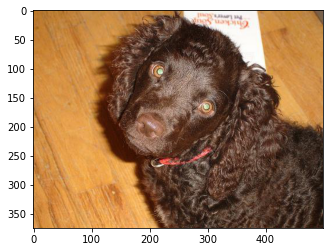

Hello, Dog!
Your breed is ...
Boykin spaniel 

File Name:  Brittany_02625


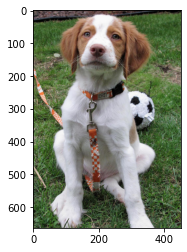

Hello, Dog!
Your breed is ...
Brittany 

File Name:  cat1


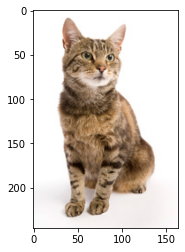

Human/dog face not detected in the image

File Name:  cat2


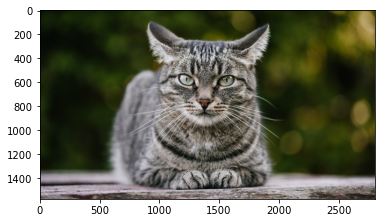

Human/dog face not detected in the image

File Name:  Curly-coated_retriever_03896


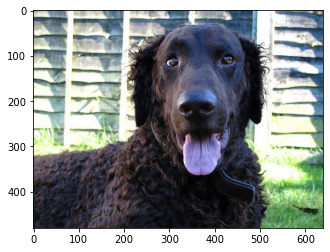

Hello, Dog!
Your breed is ...
Curly-coated retriever 

File Name:  germanshepherd


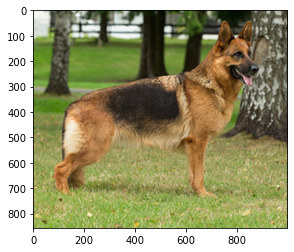

Hello, Dog!
Your breed is ...
German shepherd dog 

File Name:  human1


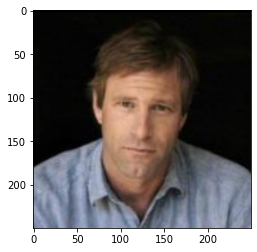

Hello, Human!
You look like a ...
Silky terrier 

File Name:  human2


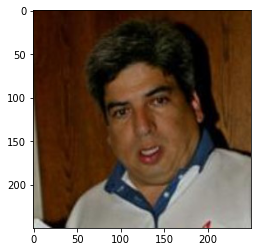

Hello, Human!
You look like a ...
Poodle 

File Name:  Labrador_retriever_06449


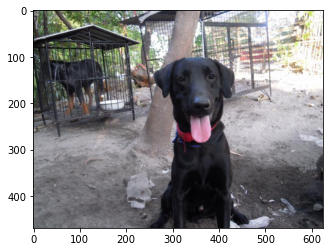

Hello, Dog!
Your breed is ...
Labrador retriever 

File Name:  Labrador_retriever_06455


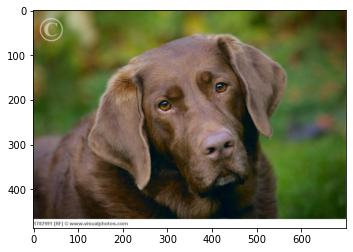

Hello, Dog!
Your breed is ...
Labrador retriever 

File Name:  Labrador_retriever_06457


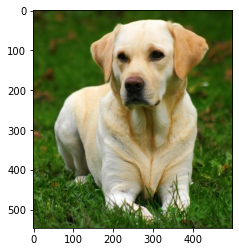

Hello, Dog!
Your breed is ...
Labrador retriever 

File Name:  nature


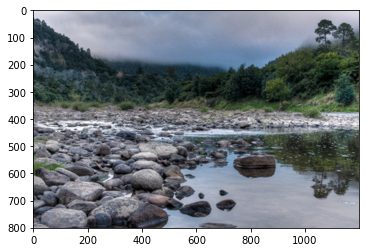

Human/dog face not detected in the image

File Name:  nature2


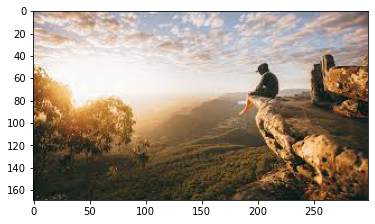

Human/dog face not detected in the image

File Name:  Welsh_springer_spaniel_08203


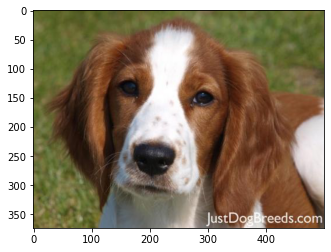

Hello, Dog!
Your breed is ...
Welsh springer spaniel 



In [63]:
test_files = np.array(glob("sample_test\*"))
for file in test_files:
    print("File Name: ",file.split("\\")[1].split(".")[0])
    run_app(file)